In [ ]:
import requests
from bs4 import BeautifulSoup
import re
import pickle
import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
def link_extractor():
    links_list = []
    for j in tqdm.tqdm(range(1, 10)):
        url = f'https://entrackr.com/category/weekly-funding-report/page/{j}/'
        txt = requests.get(url)
        txt = txt.content
        txt_bs = BeautifulSoup(txt, 'html.parser')
        articles_txt = txt_bs.find_all('article')
        links = txt_bs.find_all('h3', class_="elementor-heading-title elementor-size-default")
        for i in links:
            try:
                link_bs = BeautifulSoup(str(i), 'html.parser')
                links_list.append(link_bs.find('a')['href'])
            except:
                pass
    return links_list

In [ ]:
links = link_extractor()

100%|██████████| 9/9 [00:36<00:00,  4.06s/it]


In [ ]:
links[:5]

['https://entrackr.com/2023/08/funding-and-acquisition-in-indian-startups-this-week-31-july-04-aug/',
 'https://entrackr.com/2023/07/funding-and-acquisition-in-indian-startups-this-week-24-29-july/',
 'https://entrackr.com/2023/07/funding-and-acquisition-in-indian-startups-this-week-17-22-july/',
 'https://entrackr.com/2023/07/funding-and-acquisitions-in-indian-startups-this-week-10-15-july/',
 'https://entrackr.com/2023/07/funding-and-acquisitions-in-indian-startups-this-week-03-08-july/']

In [ ]:
len(links)

215

In [ ]:
dataset= []

In [ ]:
for i in links:
    try:
        txt = requests.get(i)
        txt = txt.content
        txt_bs = BeautifulSoup(txt, 'html.parser')
        date = txt_bs.find_all('span', class_="elementor-icon-list-text elementor-post-info__item elementor-post-info__item--type-date")[0].get_text().strip()
        txt_bs = BeautifulSoup(str(txt_bs.find('p')), 'html.parser')
        text = txt_bs.get_text()
        deal = re.findall(r'\b(\d+)', text)
        funding_amount = re.findall(r'\$([\d,]+(?:\.\d{2})?) million', text)
        pattern = r'\$([\d,]+(?:\.\d{1,2})?) million'
        match = re.search(pattern, text)
        if match:
            number = match.group(1).replace(',', '')
        dataset.append([date, deal[0], number])
        print(dataset[-1])
    except:
        print("error")

In [ ]:
dataset[:5]

[['August 5, 2023', '11', '66'],
 ['July 29, 2023', '20', '51'],
 ['July 22, 2023', '19', '113'],
 ['July 15, 2023', '22', '119'],
 ['July 8, 2023', '19', '172']]

In [ ]:
with open("dataset_files.pkl", 'wb') as f:
    pickle.dump(dataset, f)

In [ ]:
dataset_df = pd.DataFrame(dataset, columns = ['date','no_of_deals', 'total_funding'])
dataset_df = dataset_df.set_index('date')
dataset_df.index = pd.to_datetime(dataset_df.index)

In [ ]:
dataset_df

,no_of_deals,total_funding
date,,
2023-08-05,11,66
2023-07-29,20,51
2023-07-22,19,113
2023-07-15,22,119
2023-07-08,19,172
...,...,...
2019-05-04,17,166
2019-03-16,22,244
2019-03-02,16,194


In [ ]:
dataset_df.to_csv("dataset_df.csv")

In [ ]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 212 entries, 2023-08-05 to 2019-02-16
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   no_of_deals    212 non-null    object
 1   total_funding  212 non-null    object
dtypes: object(2)
memory usage: 5.0+ KB


In [ ]:
dataset_df['no_of_deals'] = dataset_df['no_of_deals'].astype('int')
dataset_df['total_funding'] = dataset_df['total_funding'].astype('float')

In [ ]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 212 entries, 2023-08-05 to 2019-02-16
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   no_of_deals    212 non-null    int64  
 1   total_funding  212 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 5.0 KB


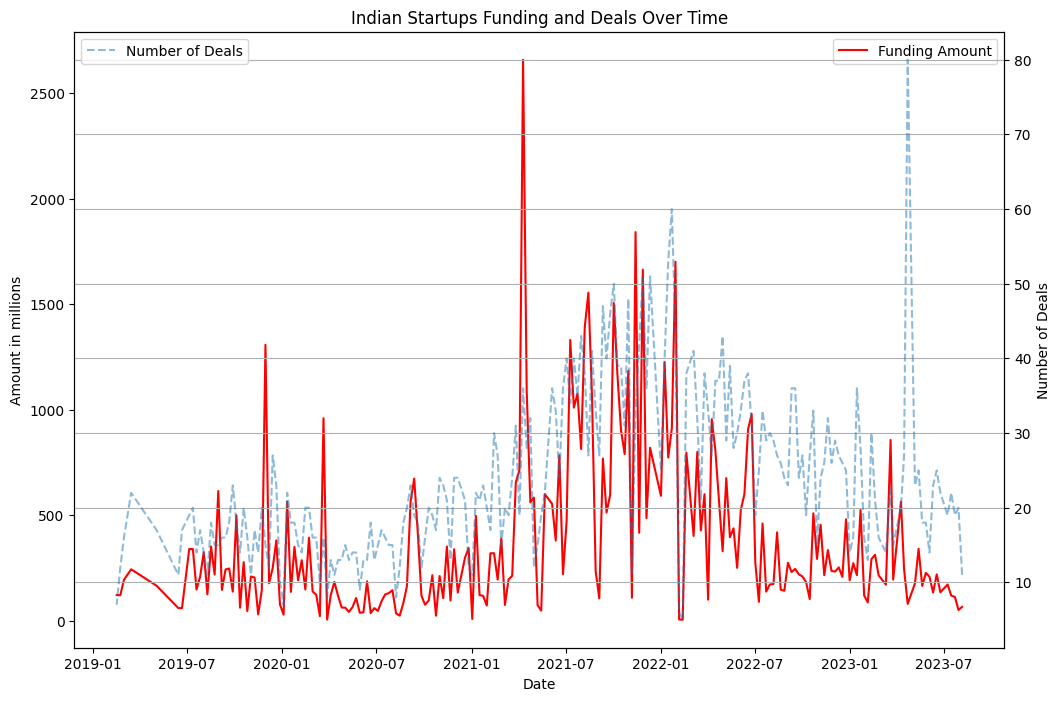

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 8))
ax2 = ax1.twinx()

plt.xticks(rotation=45)
ax1.set_xlabel('Date')

ax1.plot(dataset_df['total_funding'], color='red', label='Funding Amount')
ax1.set_ylabel('Amount in millions')
ax1.legend()

ax2.plot(dataset_df['no_of_deals'], linestyle='--', alpha=0.5, label='Number of Deals')
ax2.set_ylabel('Number of Deals')
ax2.legend()

plt.title('Indian Startups Funding and Deals Over Time')
plt.grid()
plt.show()

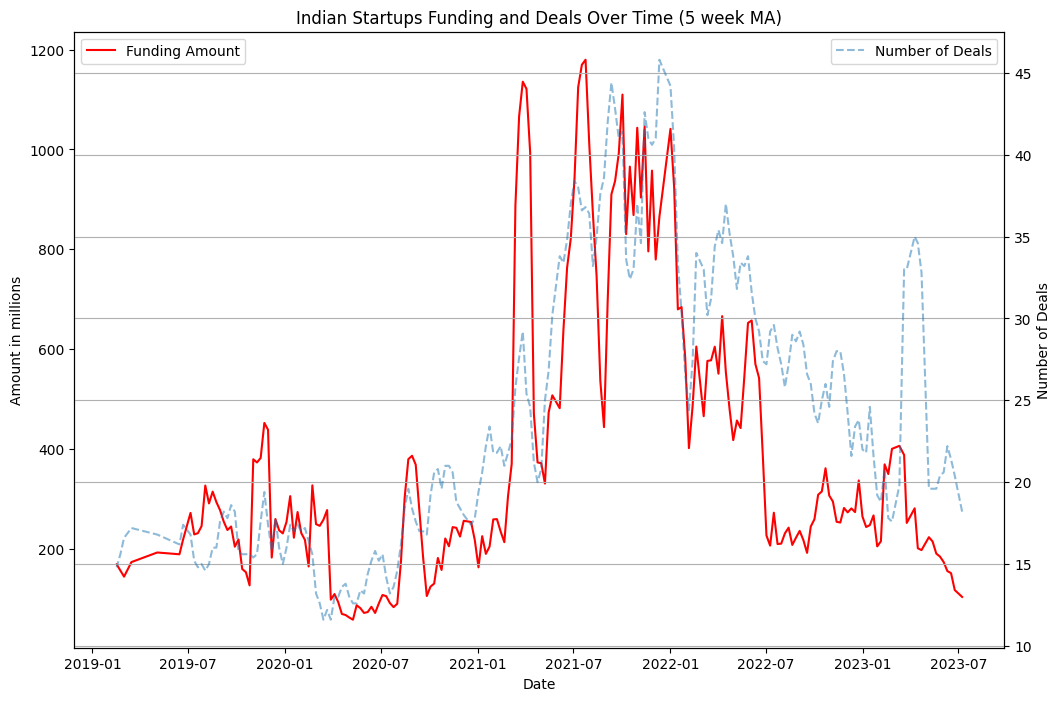

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 8))
ax2 = ax1.twinx()

plt.xticks(rotation=45)
ax1.set_xlabel('Date')

ax1.plot(dataset_df.iloc[:, 1].rolling(5).mean().dropna(), color='red', label='Funding Amount')
ax1.set_ylabel('Amount in millions')
ax1.legend(loc = 'upper left')

ax2.plot(dataset_df.iloc[:, 0].rolling(5).mean().dropna(), linestyle='--', alpha=0.5, label='Number of Deals')
ax2.set_ylabel('Number of Deals')
ax2.legend()

plt.title('Indian Startups Funding and Deals Over Time (5 week MA)')
plt.grid()
plt.show()

In [ ]:
dataset_df['quarter'] = dataset_df.index.quarter

In [ ]:
dataset_df_quarter = dataset_df.groupby(['year', 'quarter']).sum()

In [ ]:
dataset_df_quarter.head()

no_of_deals  total_funding  month
year quarter                                   
2019 1                 57          681.0      4
     2                 45          286.0      6
     3                216         3448.0     39
     4                217         3671.0     52
2020 1                200         3350.7     13

Text(0.5, 1.0, 'Quartely Fundings')

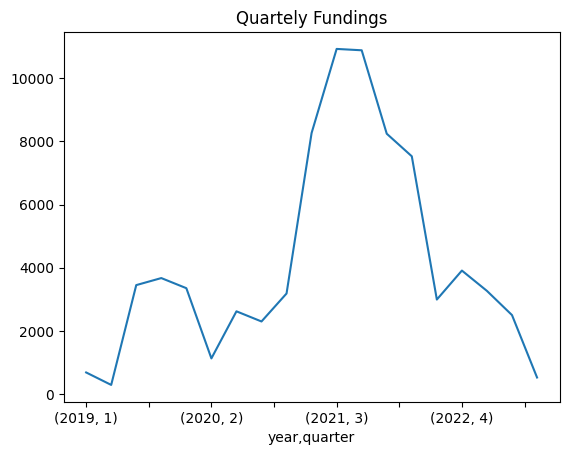

In [ ]:
dataset_df_quarter['total_funding'].plot()
plt.title('Quartely Fundings')

Text(0.5, 1.0, 'Quartely Deals')

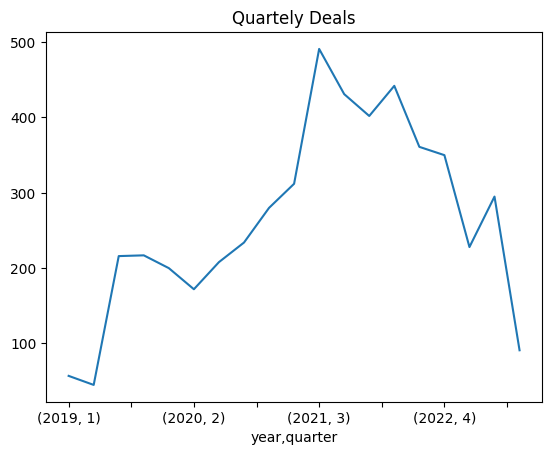

In [ ]:
dataset_df_quarter['no_of_deals'].plot()
plt.title('Quartely Deals')

In [ ]:
dataset_df['month'] = dataset_df.index.month
dataset_df['year'] = dataset_df.index.year

In [ ]:
dataset_df_monthly = dataset_df.groupby(['year', 'month']).sum()

In [ ]:
dataset_df_monthly.head()

no_of_deals  total_funding
year month                            
2019 1               57          681.0
     2               45          286.0
     3              216         3448.0
     4              217         3671.0
2020 1              200         3350.7

Text(0.5, 1.0, 'Monthly Fundings')

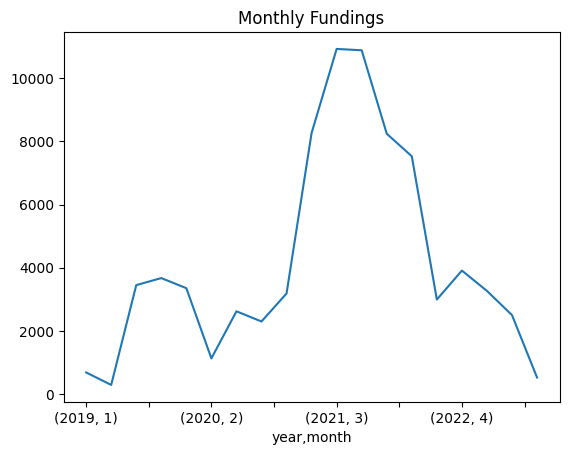

In [ ]:
dataset_df_monthly['total_funding'].plot()
plt.title('Monthly Fundings')

Text(0.5, 1.0, 'Monthly Deals')

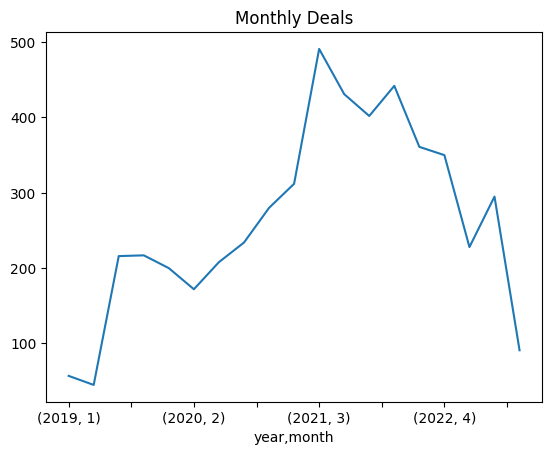

In [ ]:
dataset_df_monthly['no_of_deals'].plot()
plt.title('Monthly Deals')